In [4]:
%load_ext autoreload
%autoreload 2

# from src.datasets import *
from src.datamodule import KH9CdDataModule
from main import read_rois_from_geopackage
from torchgeo.datasets.utils import BoundingBox
import torch
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
aoi_test_small = BoundingBox(119736.8306800332211424,120771.4748695194866741,487192.3094612115528435,487754.0150268116849475,0,1)


old_images_dir = 'C:/masterarbeit/raster/KH-9/amsterdam/georeferenced/'
old_images_dir = 'C:/masterarbeit/raster/KH-9/amsterdam/georeferenced/filtered'
new_images_dir = 'C:/masterarbeit/raster/aerial_images_2023'
bag_buildings_dir = 'C:/masterarbeit/vector/buildings'
experiment_name = 'nb_test'
experiment_dir = 'nb_test'
log_dir = 'C:/masterarbeit/early_fusion/logs'
batch_size = 2
patch_size = 256
learning_rate = 0.0001
num_dataloader_workers = 8
val_split_pct = 0.2
test_split_pct = 0.1
# checkpoint_name = args.checkpoint_name
rois = read_rois_from_geopackage('C:/masterarbeit/vector/dataset_splits.gpkg')
aoi = None
task = 'ChangeStarFarSeg'


## Datamodule and augmentation testing

In [12]:
datamodule = KH9CdDataModule(
    old_images_dir=old_images_dir,
    new_images_dir=new_images_dir,
    bag_buildings_dir=bag_buildings_dir,
    batch_size=batch_size,
    num_workers=num_dataloader_workers,
    patch_size=patch_size,
    val_split_pct=val_split_pct,
    test_split_pct=test_split_pct,
    rois=rois,
    aoi=aoi,
)

datamodule.setup("fit")

In [13]:
from torchgeo.datasets import unbind_samples

loader = datamodule.train_dataloader()
batch = next(iter(loader))


In [14]:
from src.task import CustomSemanticSegmentationTask

model = CustomSemanticSegmentationTask(
    model='unet',
    backbone='resnet50',
    weights=True,
    in_channels=4,
    num_classes=2,
    loss="ce",
    ignore_index=99,
    lr=1e-4,
    patience=10,
)
model.eval()


CustomSemanticSegmentationTask(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

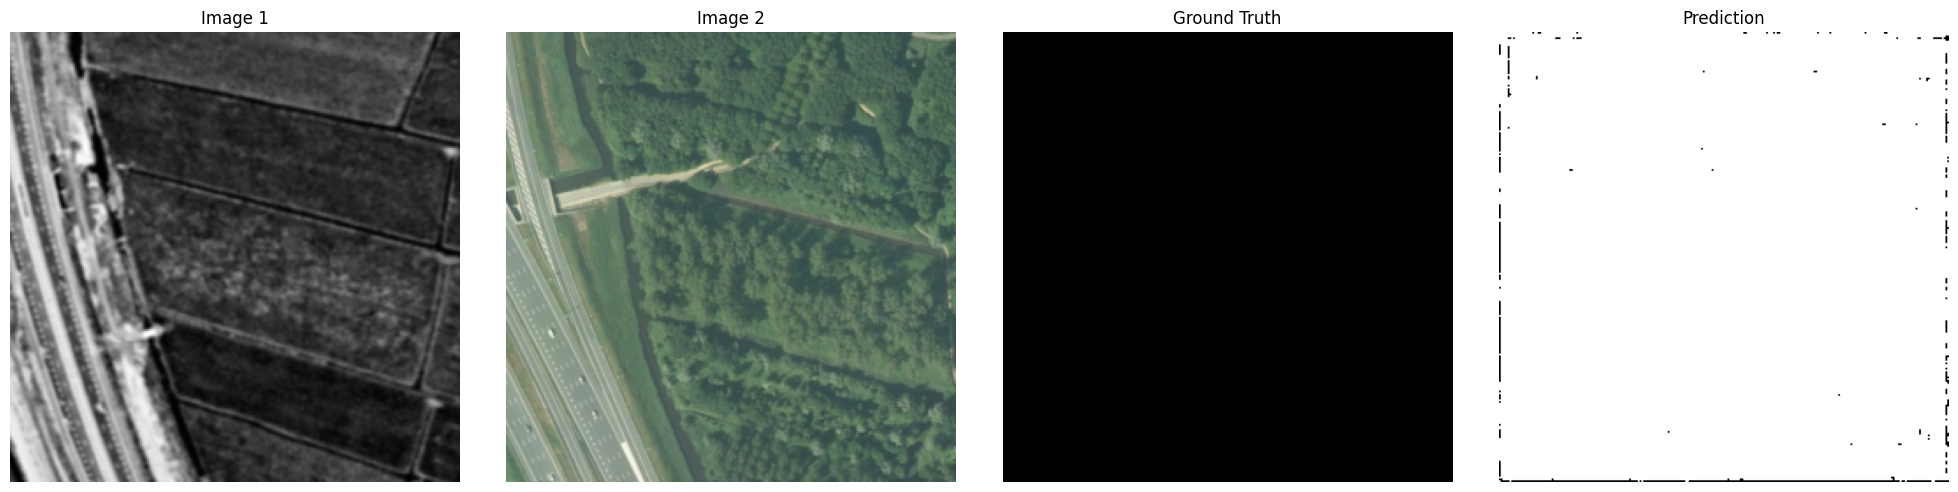

Step 0 - Loss: 25.3105


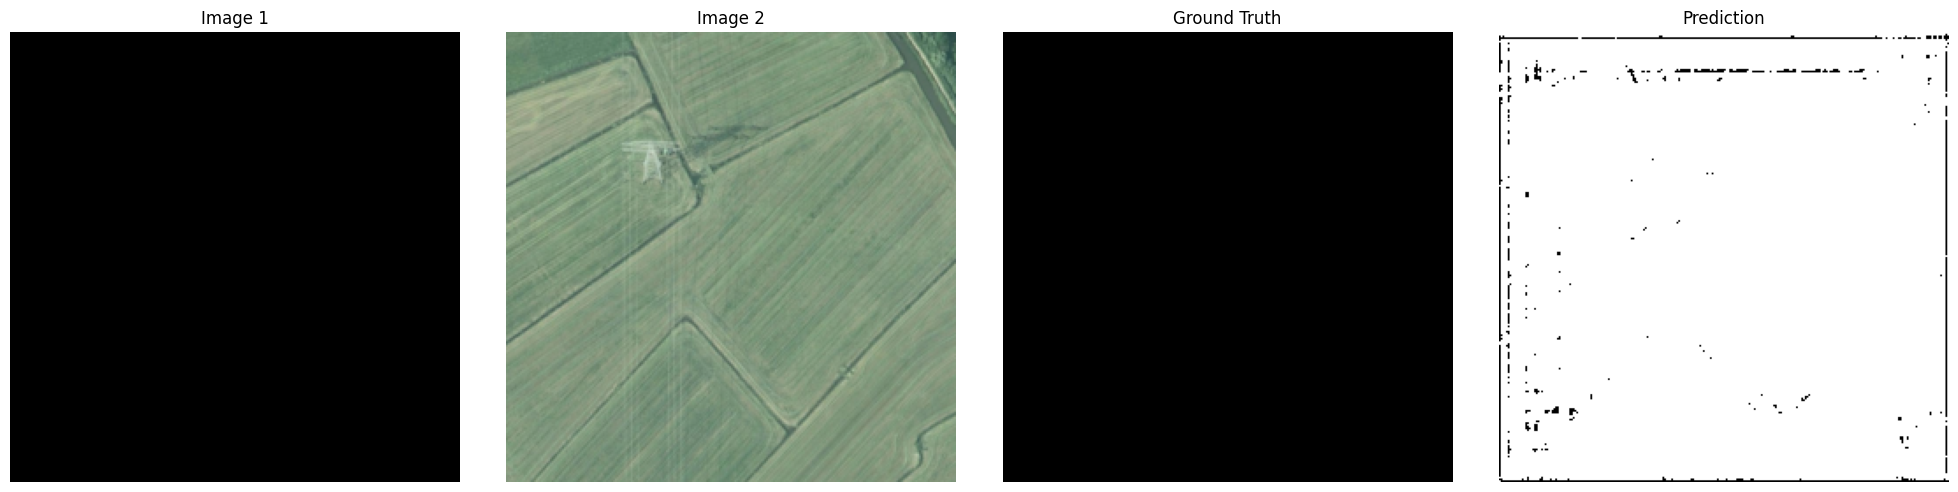

Step 1 - Loss: 17.7583


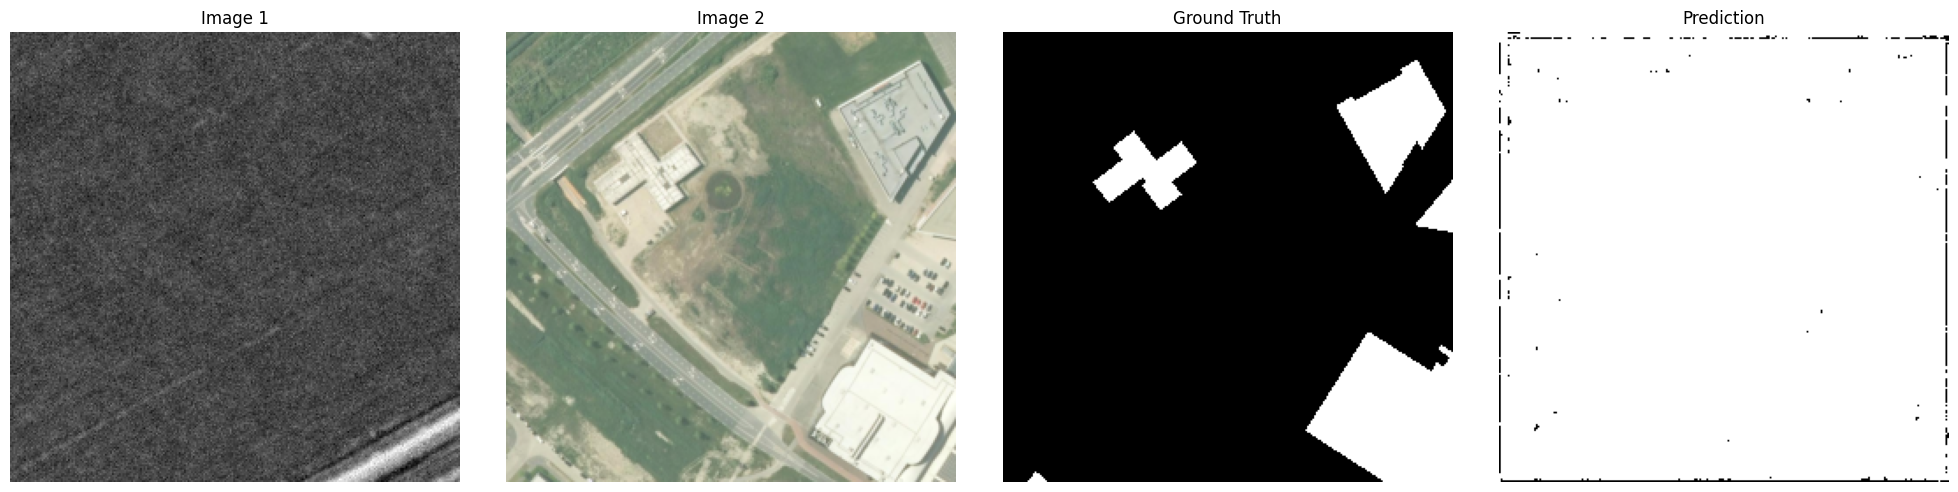

Step 2 - Loss: 22.8482


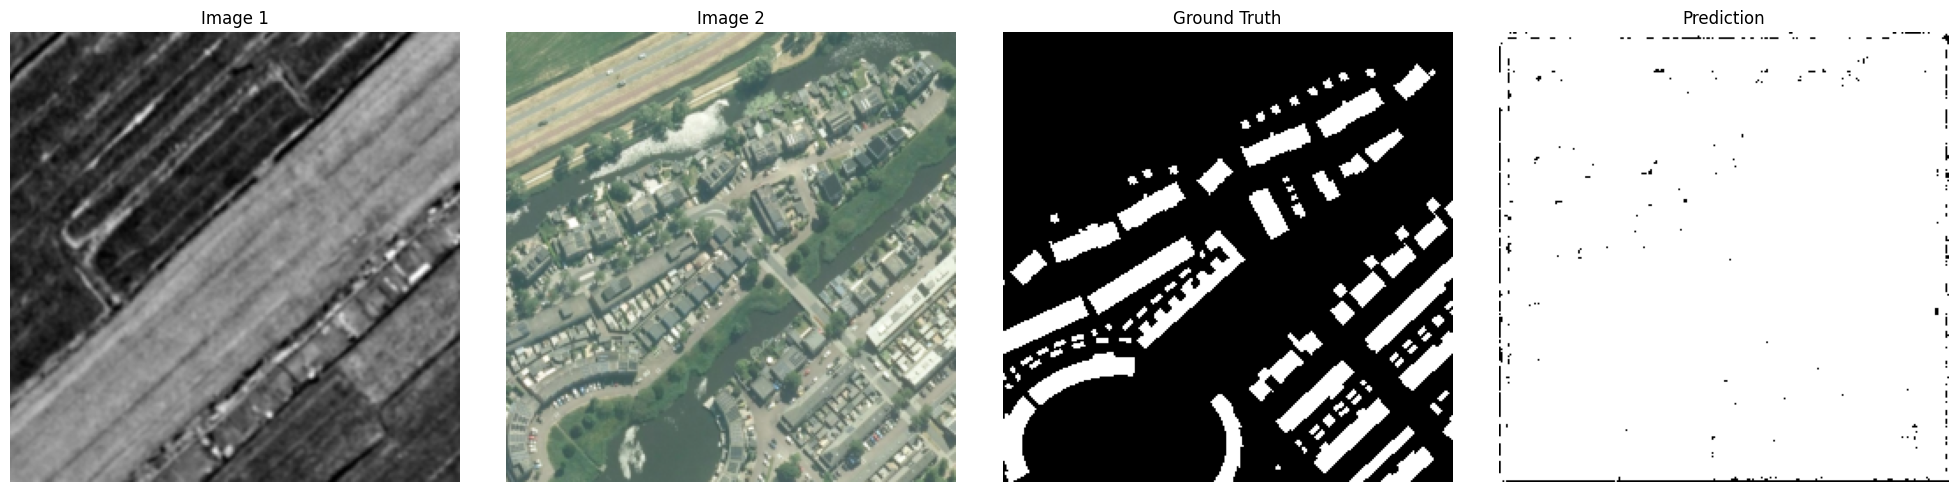

Step 3 - Loss: 20.8763


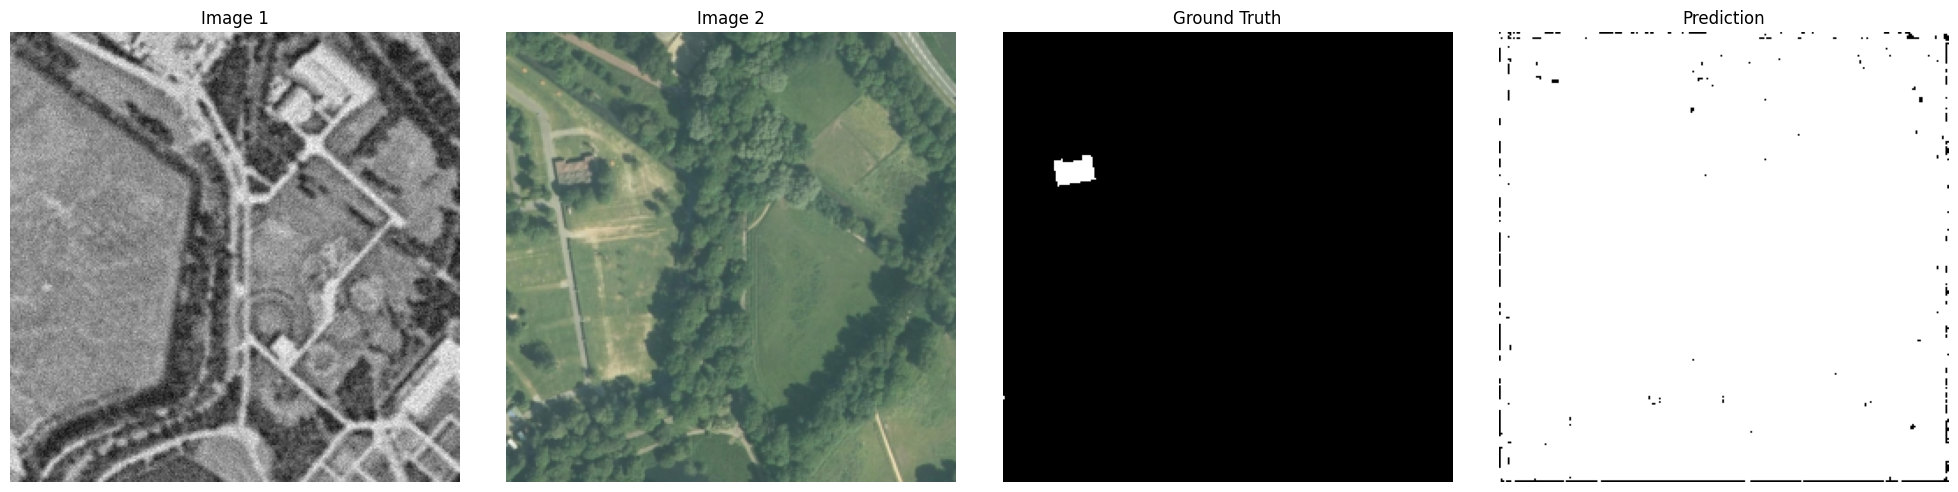

Step 4 - Loss: 20.0913


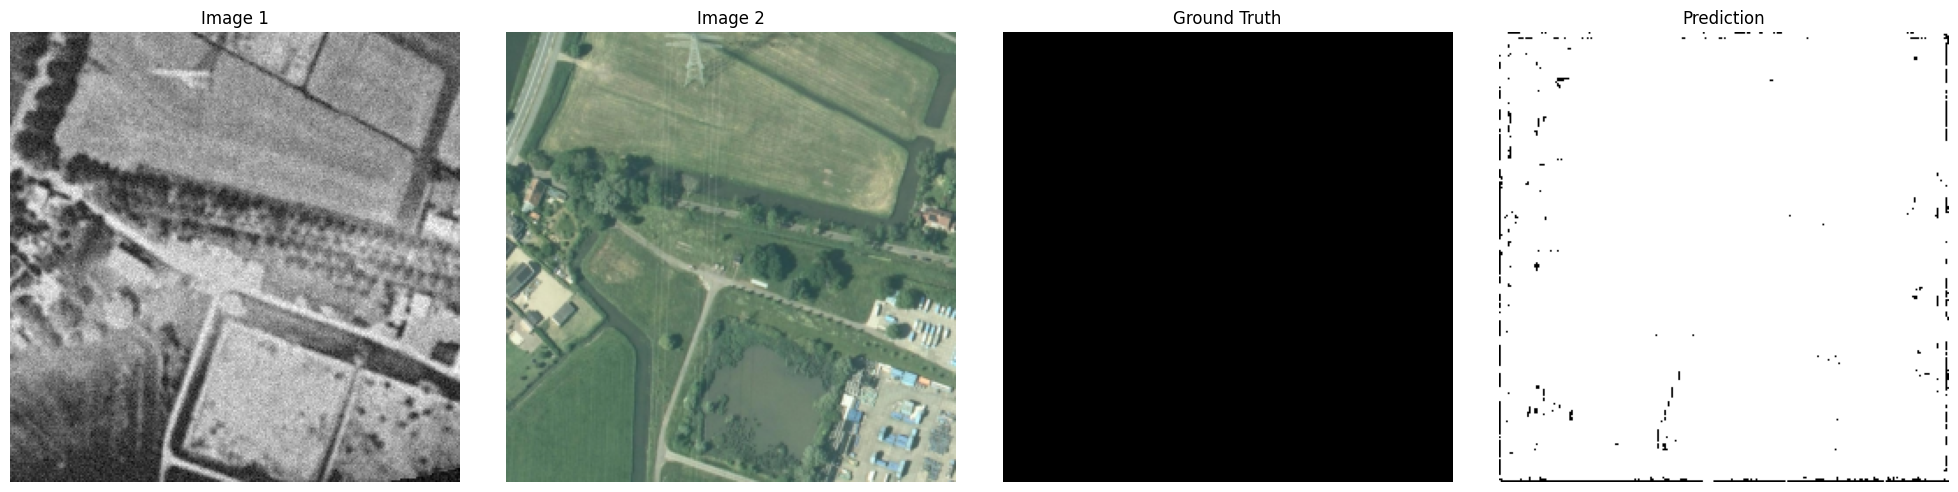

Step 5 - Loss: 22.1053


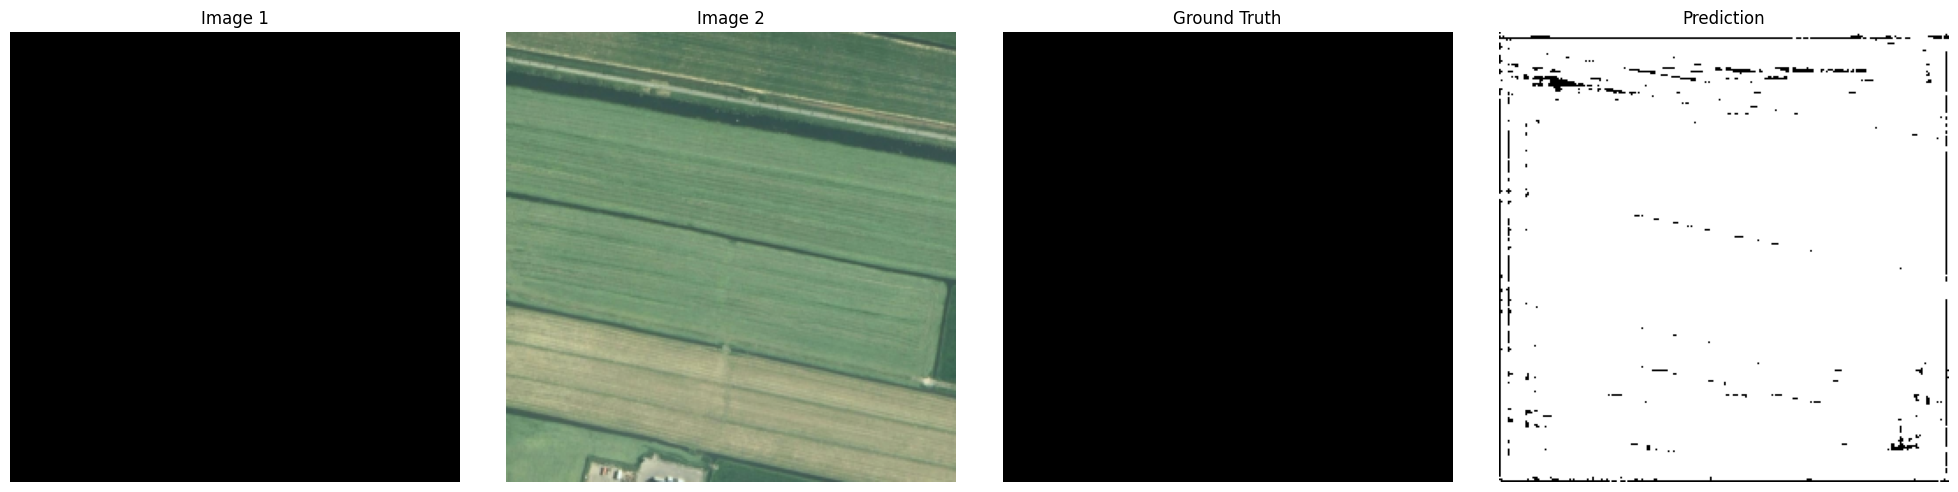

Step 6 - Loss: 19.4957


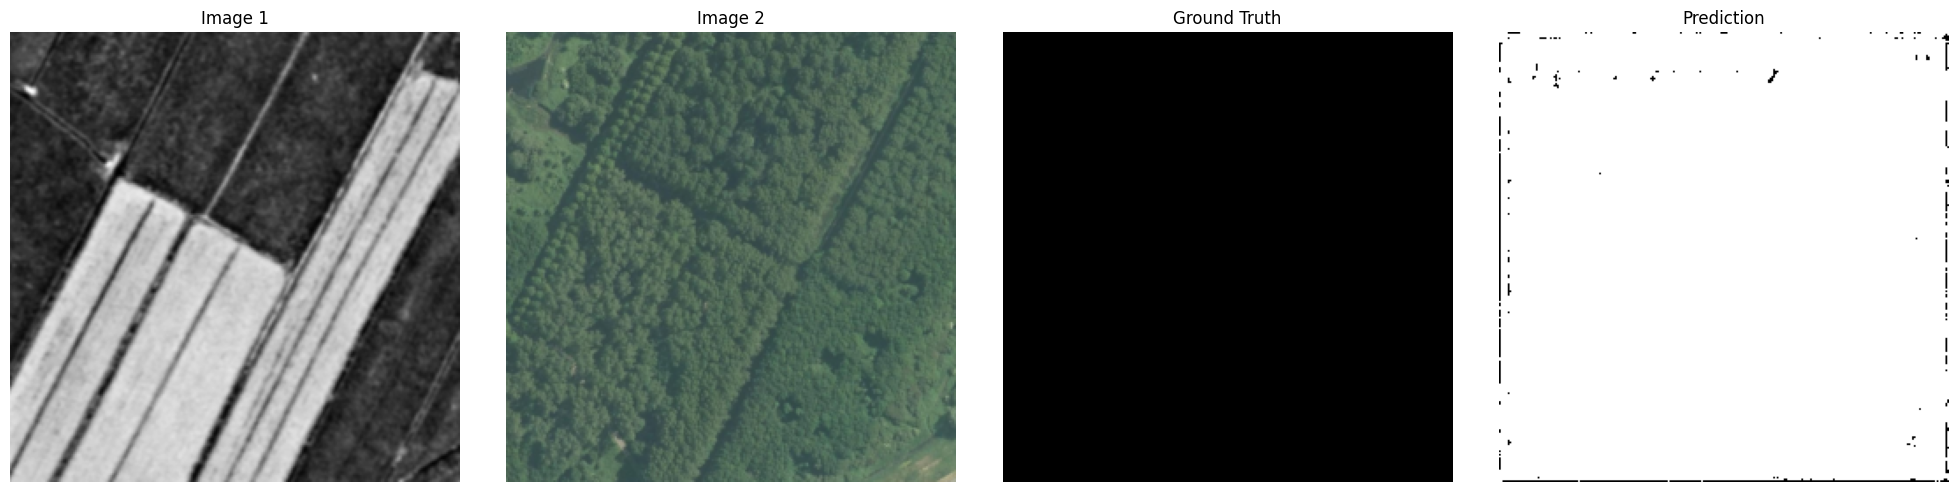

Step 7 - Loss: 22.3108


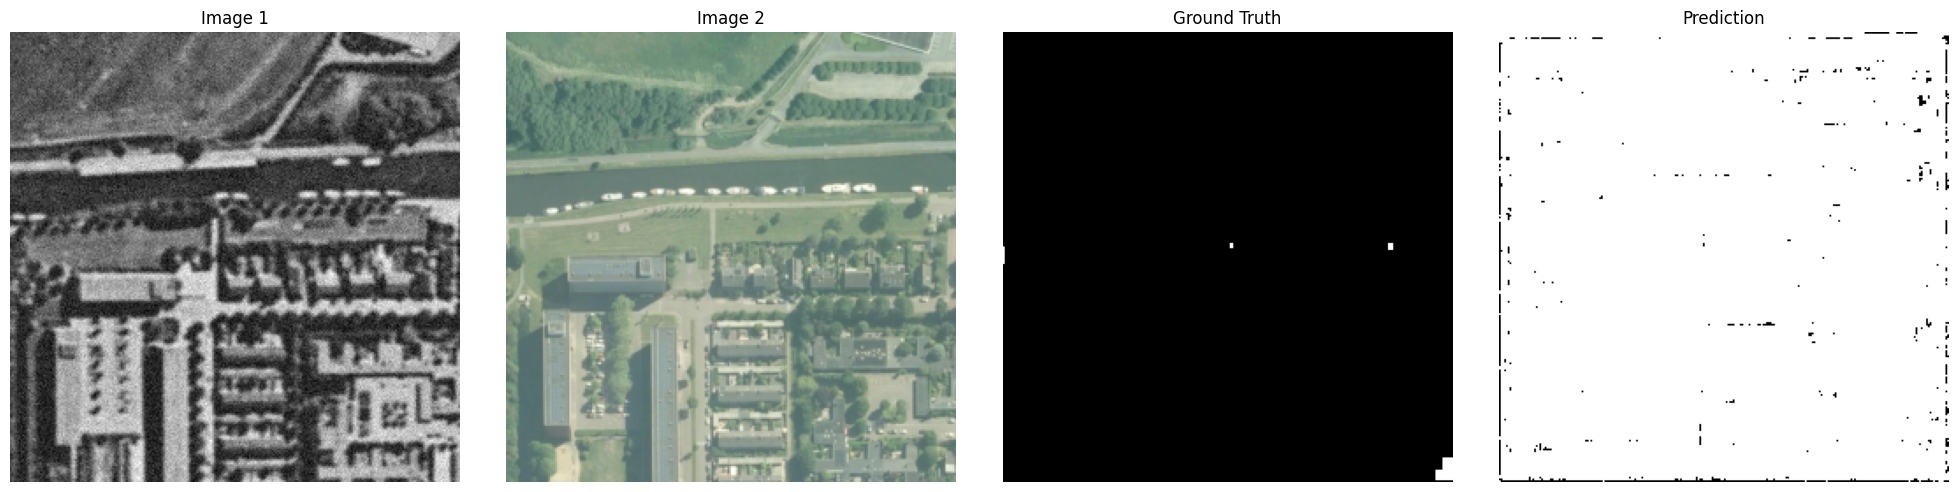

Step 8 - Loss: 27.7189


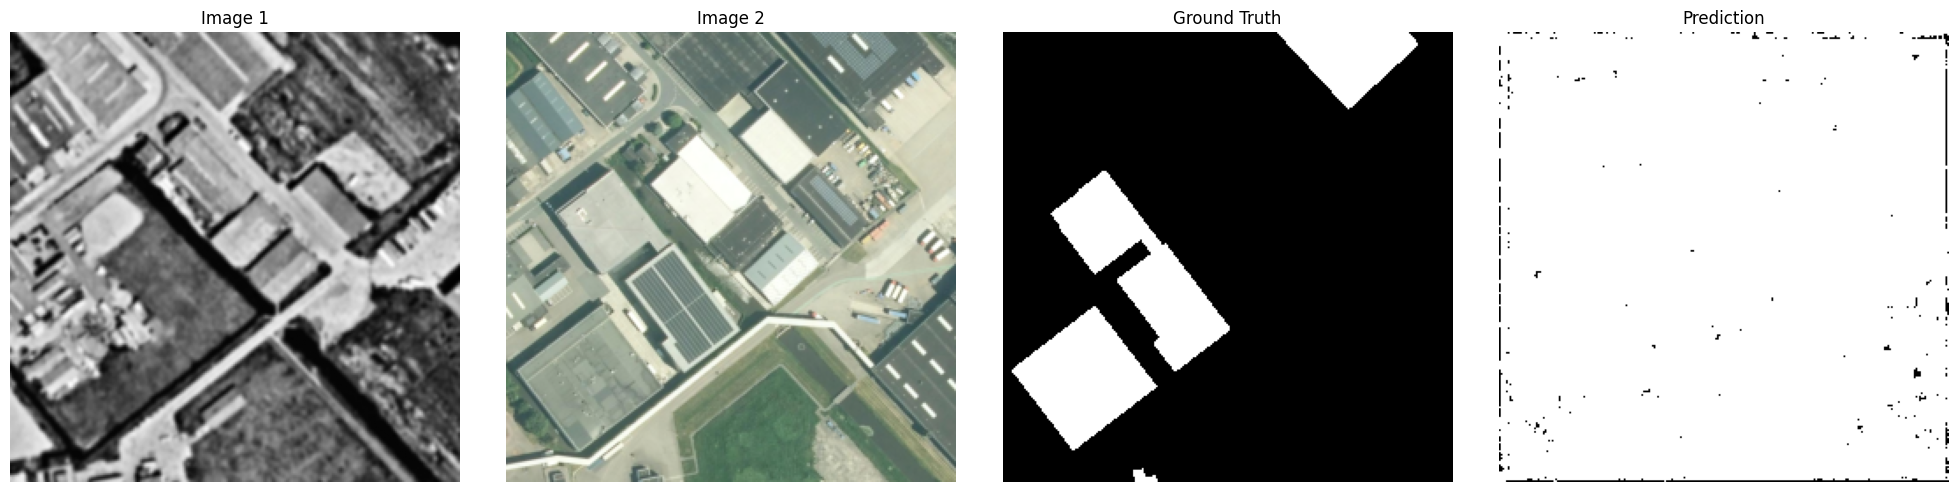

Step 9 - Loss: 21.7346


In [15]:
import copy

# Re-fetch fresh batch generator
dataloader = datamodule.train_dataloader()
iterator = iter(dataloader)

for idx in range(10):
    batch = next(iterator)
    batch_copy = copy.deepcopy(batch)  # Prevent mutation
    loss = model.training_step(batch_copy, idx)
    print(f"Step {idx} - Loss: {loss.item():.4f}")
